In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
from pandasql import sqldf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
import operator
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
from sklearn import linear_model
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

In [2]:
df = pd.read_csv('62920_1254870_compressed_vehicles.csv.zip')
df.shape

(435849, 25)

In [3]:
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435849 entries, 0 to 435848
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            435849 non-null  int64  
 1   url           435849 non-null  object 
 2   region        435849 non-null  object 
 3   region_url    435849 non-null  object 
 4   price         435849 non-null  int64  
 5   year          434732 non-null  float64
 6   manufacturer  415102 non-null  object 
 7   model         429650 non-null  object 
 8   condition     249043 non-null  object 
 9   cylinders     269465 non-null  object 
 10  fuel          432858 non-null  object 
 11  odometer      360701 non-null  float64
 12  title_status  434043 non-null  object 
 13  transmission  433703 non-null  object 
 14  vin           239197 non-null  object 
 15  drive         313838 non-null  object 
 16  size          139888 non-null  object 
 17  type          318741 non-null  object 
 18  pain

In [5]:
# number of null values in each row
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

year              1117
manufacturer     20747
model             6199
condition       186806
cylinders       166384
fuel              2991
odometer         75148
title_status      1806
transmission      2146
vin             196652
drive           122011
size            295961
type            117108
paint_color     135247
image_url           24
description         27
county          435849
lat               8235
long              8235
dtype: int64

# EDA

## How I plan to take care of values (including null)
Drop these columns:
- url = drop
- region_url = drop
- title_status = drop
- vin = drop
- size = drop = very similar to type but its missing more values and not as descriptive
- paint_color = drop, too many Nan's
- image_url = drop
- description = drop
- county = drop
- lat = drop
- long = drop

Nan to unknown:
- model = Nan to unknown
- condition = Nan to unknown, also ranked condition 0-2
- fuel = Nan to unknown
- transmission = Nan to unknown
- drive = Nan to unknown
- type = Nan to unknown
- cylinders Nan to unknown

Deleting Rows (with Nan)
- manufacturer = drop null rows
- year = drop null rows
- price = drop price = 0 and price > $300,000
- odometer = drop > 300,000

Keep how it is:
- id = keep
- region = keep
- state = keep

        After coming across this data set, I was wondering if it is possible to predict the price of a car that is being sold on craigslist. Additionally, as a seller of a car, I was wondering if it is possible to predict how much my car would be sold for if I put it on craigslist. This data set gave me the necessary columns to analyze this question and ultimately build a model with a low RMSE score. I cleaned up the data, deleted unnecessary rows, replaced some unknown variables with others that made sense and then began to answer some questions which stakeholders would find interesting. I plotted most of my graphs with price as the target variable, as that is the goal of this project. 

In [6]:
print('original shape: ', df.shape)

df.drop('url', axis=1, inplace=True)
df.drop('region_url', axis=1, inplace=True)
df.drop('title_status', axis=1, inplace=True)
# remove vin column because its missing a lot of values that hard to replace
# vin is a code from 1-30 which represents the year, but there is already a year column
df.drop('vin', axis=1, inplace=True)
df.drop('size', axis=1, inplace=True)
df.drop('paint_color', axis=1, inplace=True)
df.drop('image_url', axis=1, inplace=True)
df.drop('description', axis=1, inplace=True)
# remove county column because its literally missing every value
df.drop('county', axis=1, inplace=True)
df.drop('lat', axis=1, inplace=True)
df.drop('long', axis=1, inplace=True)

print('new shape: ', df.shape)

original shape:  (435849, 25)
new shape:  (435849, 14)


In [7]:
# number of null values in each row
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

year              1117
manufacturer     20747
model             6199
condition       186806
cylinders       166384
fuel              2991
odometer         75148
transmission      2146
drive           122011
type            117108
dtype: int64

### Deleting Rows

In [8]:
print('original shape: ', df.shape)

original shape:  (435849, 14)


Deleting Nan rows in manufacturer

In [9]:
# Manufacturer 
# I found this row to be very important for my models, therefore, since only 20,000 entries had
# Nans I decided to just delete those rows. These rows also had other missing values which by deleting them
# helped with my data set. The best way to fill in these Nans would be to go through model by model which 
# would take too long

print('old shape: ', df.shape)
df = df.dropna(how='any', subset=['manufacturer'])
print('new shape: ', df.shape)

old shape:  (435849, 14)
new shape:  (415102, 14)


Deleting Nan rows in year

In [10]:
# It is hard to know what the year is based on the odometer or other features,
# but I am able to predict the odometer based on the year.
# Therefore, I will eliminate the 8 null year rows and then impute 
# the empty odometer rows based on the year
print('old shape: ', df.shape)
df = df.dropna(how='any', subset=['year'])
print('new shape: ', df.shape)

old shape:  (415102, 14)
new shape:  (415094, 14)


Deleting rows in price

In [11]:
# The price of the car caused a lot of issues. Some prices were extreme for cars that are 
# supposed to exponentially cheaper. For any car that the price was zero, I deleted the row.
# It is very hard to fill in the price of a car without looking at the exact model due to some
# cars being antique. Therefore, I deleted all cars that are over $500,000 that were made
# after 1990 (this year was chosen after analyzing the data)

In [12]:
print('old shape: ', df.shape)
df.drop(df[(df['price'] == 0)].index, inplace=True)
print('new shape: ', df.shape)

old shape:  (415094, 14)
new shape:  (386156, 14)


In [13]:
print('old shape: ', df.shape)
df.drop(df[(df['price'] >= 300000)].index, inplace=True)
print('new shape: ', df.shape)

old shape:  (386156, 14)
new shape:  (386087, 14)


Deleting rows in odometer

In [14]:
print('old shape: ', df.shape)
df.drop(df[(df['odometer'] >= 300000)].index, inplace=True)
print('new shape: ', df.shape)

old shape:  (386087, 14)
new shape:  (384445, 14)


In [15]:
# number of null values in each row
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

model             5742
condition       158151
cylinders       143718
fuel              2381
odometer         61464
transmission      1765
drive           103692
type            101875
dtype: int64

### Changed Nans to Unknown 

In [16]:
# model
df['model'].fillna('Unknown', inplace = True)
# condition
df['condition'].fillna('Unknown', inplace = True)
# fuel
df['fuel'].fillna('Unknown', inplace = True)
# transmission
df['transmission'].fillna('Unknown', inplace = True)
# drive
df['drive'].fillna('Unknown', inplace = True)
# type
df['type'].fillna('Unknown', inplace = True)
# cylinders
df['cylinders'].fillna('Unknown', inplace = True)

conditon column: ranked condition of car from 0-2

In [17]:
df.condition = df.condition.replace({'new':2, 'like new':2, 'excellent':2,
                                     'good':1,'fair':1,
                                     'salvage':0})

add an age column 

In [18]:
df['age'] = 2021 - df['year']

In [19]:

df['year'].values[df['year'] <= 1950] = 1950
df['year'] = np.where((df['year'] <= 1960) & (df['year'] > 1950), 1960, df['year'])
df['year'] = np.where((df['year'] <= 1970) & (df['year'] > 1960), 1970, df['year']) 
df['year'] = np.where((df['year'] <= 1980) & (df['year'] > 1970), 1980, df['year'])
df['year'] = np.where((df['year'] <= 1990) & (df['year'] > 1980), 1990, df['year'])
df['year'] = np.where((df['year'] <= 2000) & (df['year'] > 1990), 2000, df['year'])
df['year'] = np.where((df['year'] <= 2005) & (df['year'] > 2000), 2005, df['year'])
df['year'] = np.where((df['year'] <= 2010) & (df['year'] > 2005), 2010, df['year'])
df['year'] = np.where((df['year'] <= 2015) & (df['year'] > 2010), 2015, df['year'])

In [20]:
odom_year = sqldf("""select year, count(year), avg(odometer) as avg_od
            from df
            group by year
            order by year DESC
            limit 15""")
df.groupby(['year'])[['odometer']].median()

,odometer
year,
1950.0,8000.0
1960.0,34170.0
1970.0,54891.0
1980.0,68154.0
1990.0,96406.5
2000.0,147516.0
2005.0,150000.0
2010.0,131687.0
2015.0,92982.0


- How I handle the missing values in the odometer column

In [21]:
# number of null values in each row
null_columns=df.columns[df.isnull().any()]
print('old missing values: ', df[null_columns].isnull().sum())

#1950
df['odometer'] = np.where((df['odometer'].isna()) & (df['year'] == 1950), 8000, df['odometer'])
#1960
df['odometer'] = np.where((df['odometer'].isna()) & (df['year'] == 1960), 34000, df['odometer'])
#1970
df['odometer'] = np.where((df['odometer'].isna()) & (df['year'] == 1970), 55000, df['odometer'])
#1980
df['odometer'] = np.where((df['odometer'].isna()) & (df['year'] == 1980), 68000, df['odometer'])
#1990
df['odometer'] = np.where((df['odometer'].isna()) & (df['year'] == 1990), 96000, df['odometer'])
#2000
df['odometer'] = np.where((df['odometer'].isna()) & (df['year'] == 2000), 147000, df['odometer'])
#2005
df['odometer'] = np.where((df['odometer'].isna()) & (df['year'] == 2005), 150000, df['odometer'])
#2010
df['odometer'] = np.where((df['odometer'].isna()) & (df['year'] == 2010), 130000, df['odometer']) 
#2015
df['odometer'] = np.where((df['odometer'].isna()) & (df['year'] == 2015), 93000, df['odometer']) 
#2016
df['odometer'] = np.where((df['odometer'].isna()) & (df['year'] == 2016), 53000, df['odometer']) 
#2017
df['odometer'] = np.where((df['odometer'].isna()) & (df['year'] == 2017), 38000, df['odometer']) 
#2018
df['odometer'] = np.where((df['odometer'].isna()) & (df['year'] == 2018), 30000, df['odometer']) 
#2019
df['odometer'] = np.where((df['odometer'].isna()) & (df['year'] == 2019), 16000, df['odometer'])
#2020
df['odometer'] = np.where((df['odometer'].isna()) & (df['year'] == 2020), 1500, df['odometer']) 
#2021
df['odometer'] = np.where((df['odometer'].isna()) & (df['year'] == 2021), 66500, df['odometer']) 

# number of null values in each row
null_columns=df.columns[df.isnull().any()]
print('new missing values: ', df[null_columns].isnull().sum())

old missing values:  odometer    61464
dtype: int64
new missing values:  Series([], dtype: float64)


In [22]:
df.shape

(384445, 15)

# 3 questions with answers through EDA

### 1. How does the mileage change over time?

[Text(0, 0, '1950.0'),
 Text(0, 0, '1960.0'),
 Text(0, 0, '1970.0'),
 Text(0, 0, '1980.0'),
 Text(0, 0, '1990.0'),
 Text(0, 0, '2000.0'),
 Text(0, 0, '2005.0'),
 Text(0, 0, '2010.0'),
 Text(0, 0, '2015.0'),
 Text(0, 0, '2016.0'),
 Text(0, 0, '2017.0'),
 Text(0, 0, '2018.0'),
 Text(0, 0, '2019.0'),
 Text(0, 0, '2020.0'),
 Text(0, 0, '2021.0')]

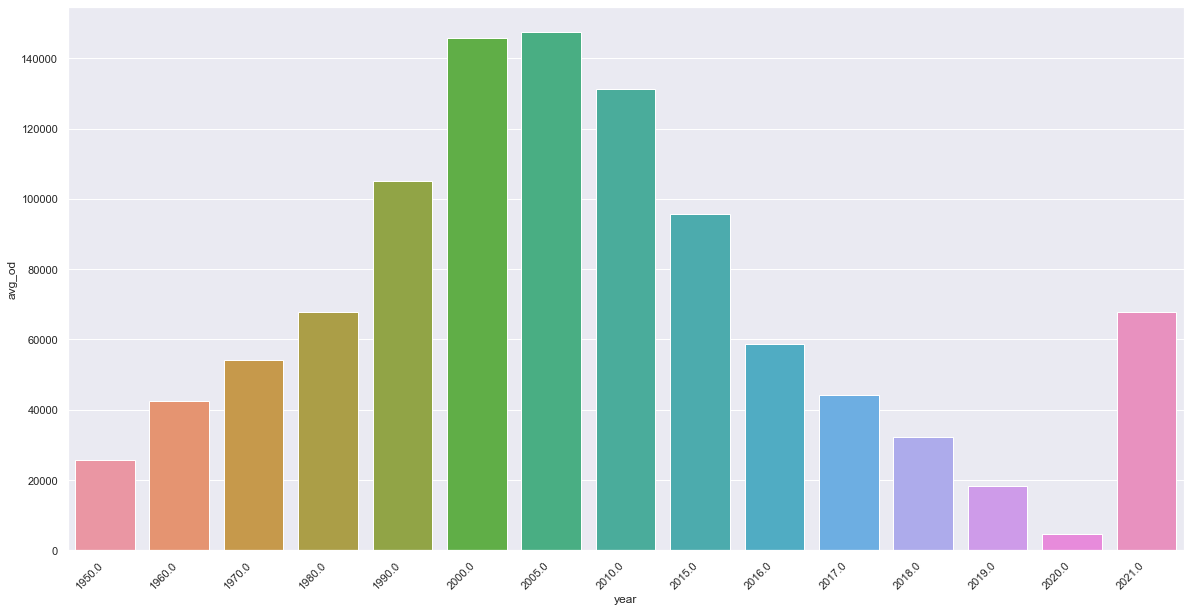

In [23]:
sns.set(style="darkgrid")
plt.figure(figsize=(20,10))
totalsChart = sns.barplot(data=odom_year, x='year',y='avg_od')
totalsChart.set_xticklabels(totalsChart.get_xticklabels(), rotation=45, horizontalalignment='right')

### 2. Which manufacturer has the most expensive cars?

    manufacturer  count(manufacturer)     avg(price)
0        ferrari                   76  105890.421053
1   aston-martin                   34   59657.470588
2          tesla                  298   46941.362416
3         morgan                    3   34166.666667
4          rover                 1713   23536.918856
5            ram                18356   21821.132927
6            gmc                17279   18478.465131
7     alfa-romeo                   60   18158.233333
8         porche                   27   17490.444444
9  mercedes-benz                 8972   16838.699398


[Text(0, 0, 'ferrari'),
 Text(0, 0, 'aston-martin'),
 Text(0, 0, 'tesla'),
 Text(0, 0, 'morgan'),
 Text(0, 0, 'rover'),
 Text(0, 0, 'ram'),
 Text(0, 0, 'gmc'),
 Text(0, 0, 'alfa-romeo'),
 Text(0, 0, 'porche'),
 Text(0, 0, 'mercedes-benz')]

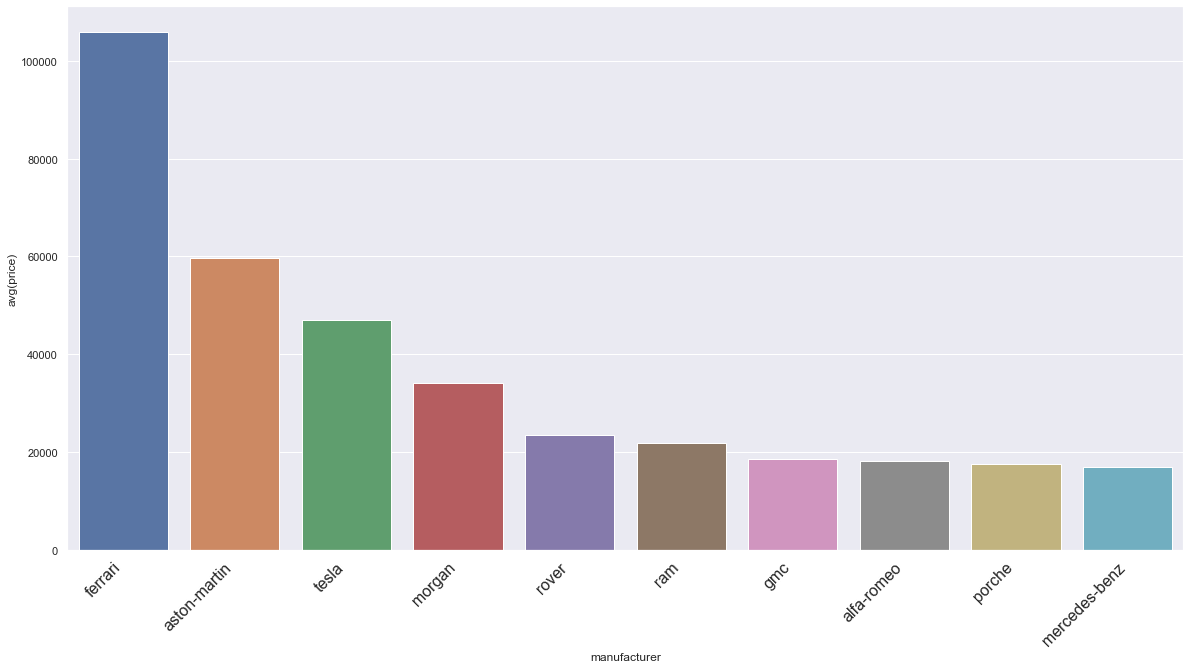

In [24]:
man_table = sqldf("""select manufacturer, count(manufacturer), avg(price)
            from df
            group by manufacturer
            order by avg(price) DESC
            limit 10""")
print(man_table)
sns.set(style="darkgrid")
plt.figure(figsize=(20,10))
totalsChart = sns.barplot(data=man_table, x='manufacturer',y='avg(price)')
totalsChart.set_xticklabels(totalsChart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=16)

### 3. Does condition matter?

  condition  count(condition)    avg(price)
0   Unknown            158151  15483.056769
1         2            132278  13131.721571
2         1             93407  11611.265922
3         0               609   3804.504105


[Text(0, 0, 'Unknown condition'),
 Text(0, 0, 'Amazing condition'),
 Text(0, 0, 'Descent condition'),
 Text(0, 0, 'Bad condition')]

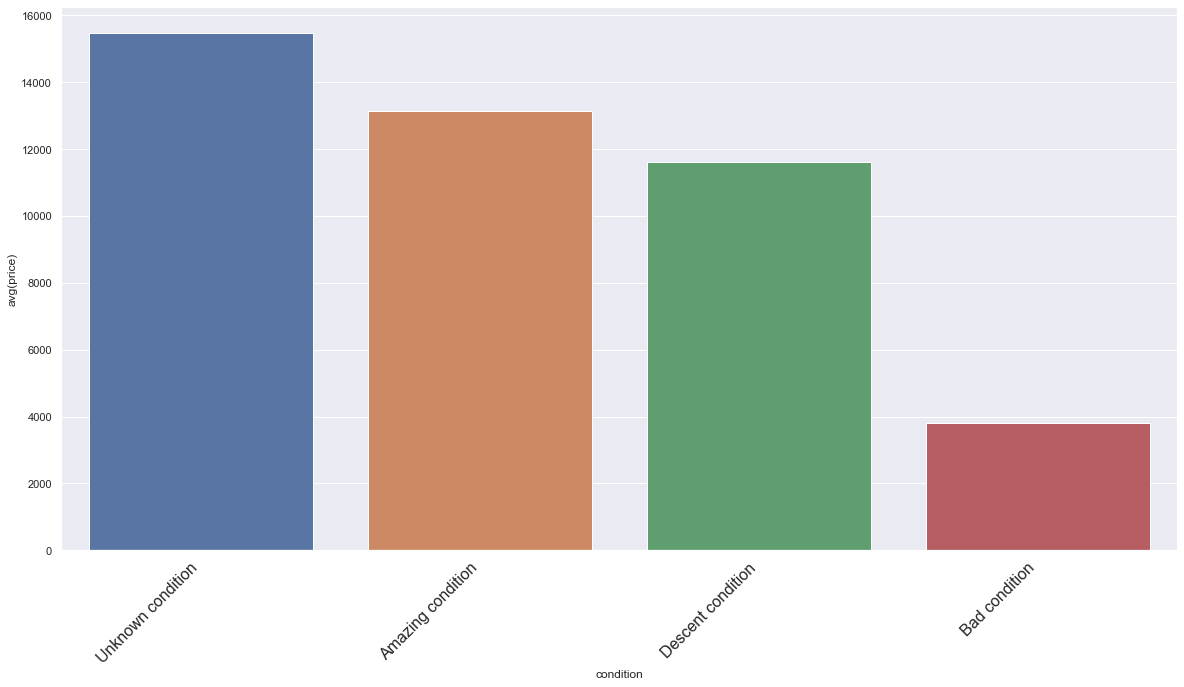

In [25]:
man_table = sqldf("""select condition, count(condition), avg(price)
            from df
            group by condition
            order by avg(price) DESC
            limit 10""")
print(man_table)
sns.set(style="darkgrid")
plt.figure(figsize=(20,10))
totalsChart = sns.barplot(data=man_table, x='condition',y='avg(price)')
totalsChart.set_xticklabels(['Unknown condition', 'Amazing condition', 'Descent condition', 'Bad condition'], rotation=45, horizontalalignment='right', fontsize=16)

-  Conclusion: As we can see the difference between a car in good condition and decent condition does not effect the price very much, but a car in very bad condition will effect the price... a lot!

# 4 Meaningful Data Visualizations

### 1. Does the type of fuel effect the price of the car?

       fuel  count(fuel)    avg(price)
0    diesel        29089  24312.401870
1  electric          895  23000.246927
2   Unknown         2381  18279.097858
3     other        10815  17467.786870
4       gas       337390  12656.881229
5    hybrid         3875  10848.710194


[Text(0, 0, 'diesel'),
 Text(0, 0, 'electric'),
 Text(0, 0, 'Unknown'),
 Text(0, 0, 'other'),
 Text(0, 0, 'gas'),
 Text(0, 0, 'hybrid')]

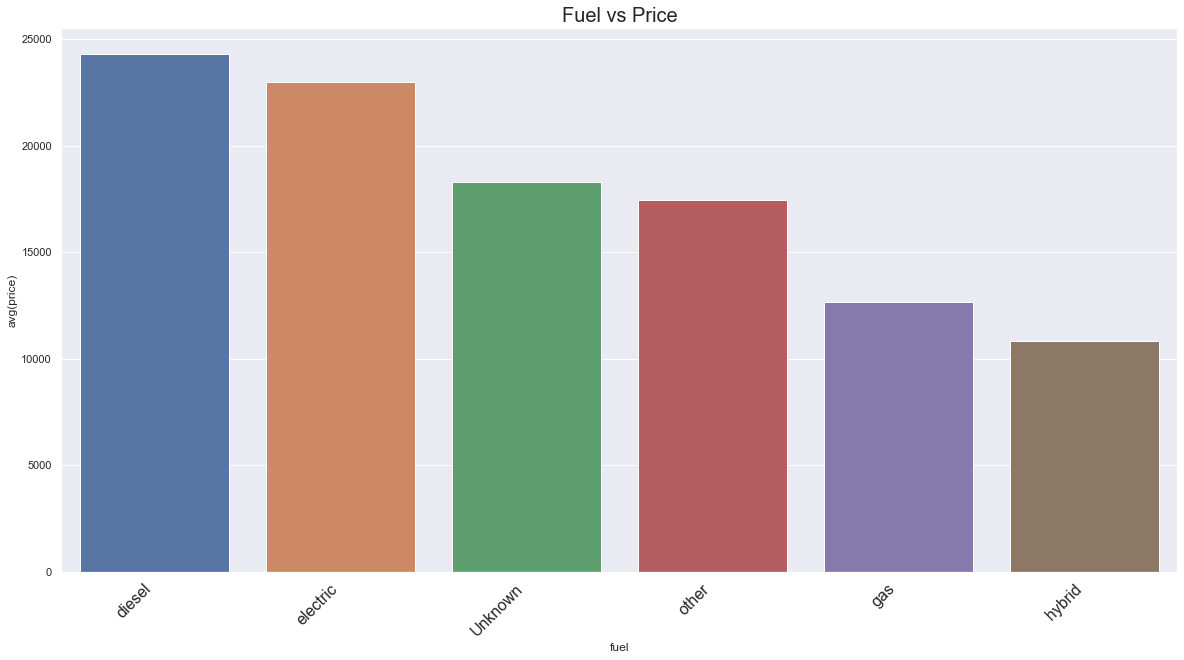

In [26]:
elec_gas_table = sqldf("""select fuel, count(fuel), avg(price)
            from df
            group by fuel
            order by avg(price) DESC
            """)
print(elec_gas_table)
sns.set(style="darkgrid")
plt.figure(figsize=(20,10))
plt.title("Fuel vs Price", fontsize =20)
totalsChart = sns.barplot(data=elec_gas_table, x='fuel',y='avg(price)')
totalsChart.set_xticklabels(totalsChart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=16)

### 2. Which antique manufacturer's cars are worth the most?

  manufacturer  count(manufacturer)     avg(price)
0      ferrari                   11  153903.454545
1       morgan                    2   45000.000000
2   land rover                    1   35000.000000
3        rover                   16   26528.187500
4       jaguar                   32   24813.968750
5    chevrolet                 2590   19932.986100
6       porche                    6   19366.666667
7      pontiac                  330   17825.693939
8       toyota                   86   17267.732558
9         ford                 2070   16575.377295


[Text(0, 0, 'ferrari'),
 Text(0, 0, 'morgan'),
 Text(0, 0, 'land rover'),
 Text(0, 0, 'rover'),
 Text(0, 0, 'jaguar'),
 Text(0, 0, 'chevrolet'),
 Text(0, 0, 'porche'),
 Text(0, 0, 'pontiac'),
 Text(0, 0, 'toyota'),
 Text(0, 0, 'ford')]

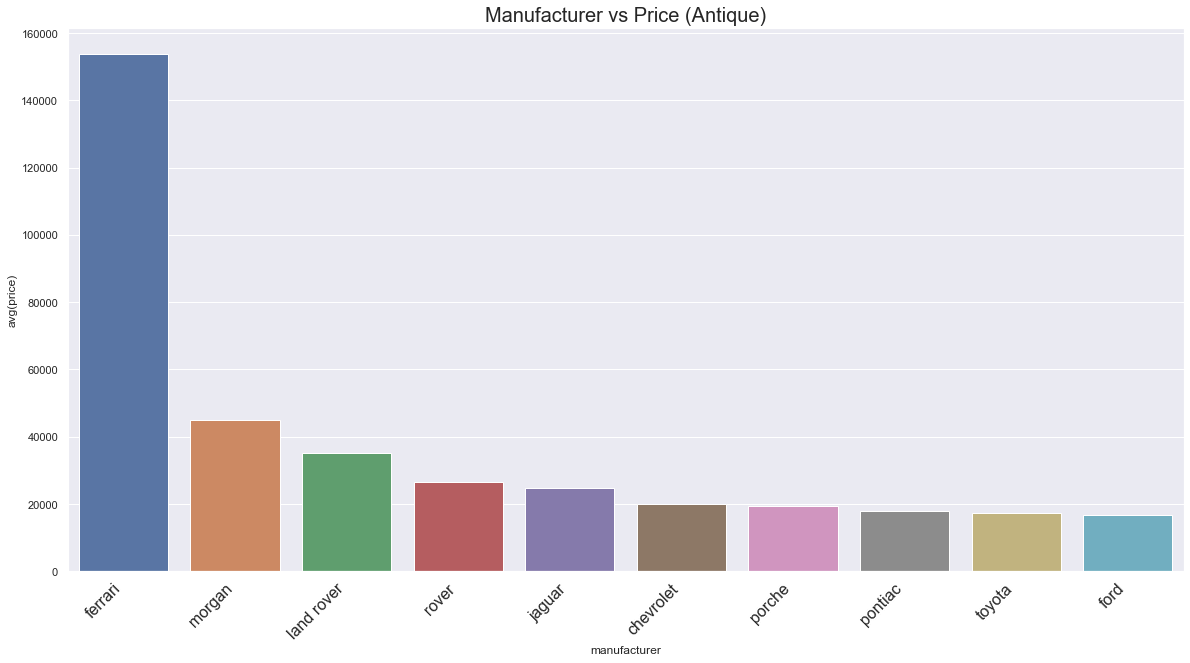

In [27]:
man_old_table = sqldf("""select manufacturer, count(manufacturer), avg(price)
            from df
            where year < 1990
            group by manufacturer
            order by avg(price) DESC
            limit 10""")
print(man_old_table)
sns.set(style="darkgrid")
plt.figure(figsize=(20,10))
plt.title("Manufacturer vs Price (Antique)", fontsize =20)
totalsChart = sns.barplot(data=man_old_table, x='manufacturer',y='avg(price)')
totalsChart.set_xticklabels(totalsChart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=16)

### 3. Which antique car models are worth the most?

                   model  count(model)  avg(price)
0              365 gtc/4             5    275000.0
1                  250se             1    135000.0
2  series 62 convertible             4    113749.0
3           280se 2-door             2    109000.0
4             benz 190sl             2     93990.0
5              resto mod             1     89000.0
6            bus/vanagon             1     88000.0
7            xke, e-type             1     84500.0
8     belair convertible             1     84000.0
9    bel air convertible             5     78699.0


[Text(0, 0, '365 gtc/4'),
 Text(0, 0, '250se'),
 Text(0, 0, 'series 62 convertible'),
 Text(0, 0, '280se 2-door'),
 Text(0, 0, 'benz 190sl'),
 Text(0, 0, 'resto mod'),
 Text(0, 0, 'bus/vanagon'),
 Text(0, 0, 'xke, e-type'),
 Text(0, 0, 'belair convertible'),
 Text(0, 0, 'bel air convertible')]

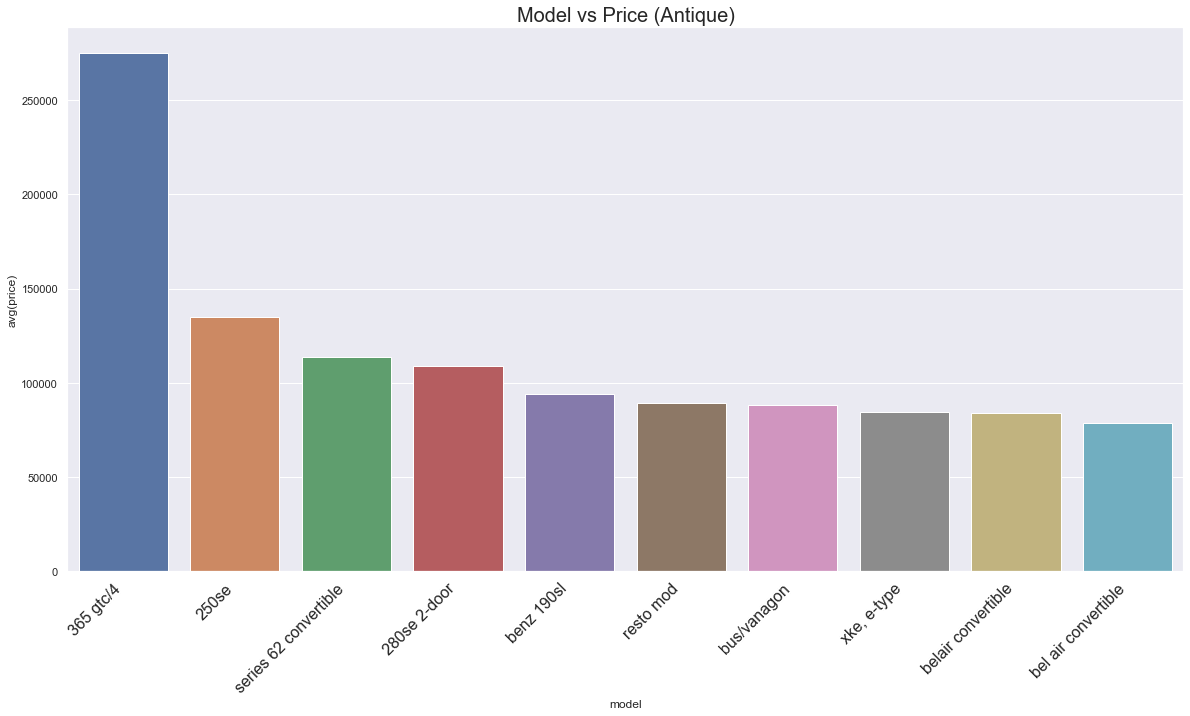

In [28]:
mod_old_table = sqldf("""select model, count(model), avg(price)
            from df
            where year < 1990
            group by model
            order by avg(price) DESC
            limit 10""")
print(mod_old_table)
sns.set(style="darkgrid")
plt.figure(figsize=(20,10))
plt.title("Model vs Price (Antique)", fontsize =20)
totalsChart = sns.barplot(data=mod_old_table, x='model',y='avg(price)')
totalsChart.set_xticklabels(totalsChart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=16)

### 4. Age vs. Avg price

      year  count(year)    avg(price)
0   2020.0         2058  37078.775996
1   2019.0        12950  27924.437375
2   2018.0        17393  23508.151095
3   2017.0        30528  21191.552051
4   1960.0          965  20806.125389
5   2016.0        28149  19832.768162
6   1970.0         2599  18980.347826
7   1950.0         1001  18303.698302
8   2015.0       135373  14602.465462
9   1980.0         2669  12802.819033
10  2010.0        86705   8358.275843
11  1990.0         3772   7696.802757
12  2005.0        43415   6238.568536
13  2021.0           28   5922.678571
14  2000.0        16840   5768.648100


[Text(0, 0, '1950.0'),
 Text(0, 0, '1960.0'),
 Text(0, 0, '1970.0'),
 Text(0, 0, '1980.0'),
 Text(0, 0, '1990.0'),
 Text(0, 0, '2000.0'),
 Text(0, 0, '2005.0'),
 Text(0, 0, '2010.0'),
 Text(0, 0, '2015.0'),
 Text(0, 0, '2016.0'),
 Text(0, 0, '2017.0'),
 Text(0, 0, '2018.0'),
 Text(0, 0, '2019.0'),
 Text(0, 0, '2020.0'),
 Text(0, 0, '2021.0')]

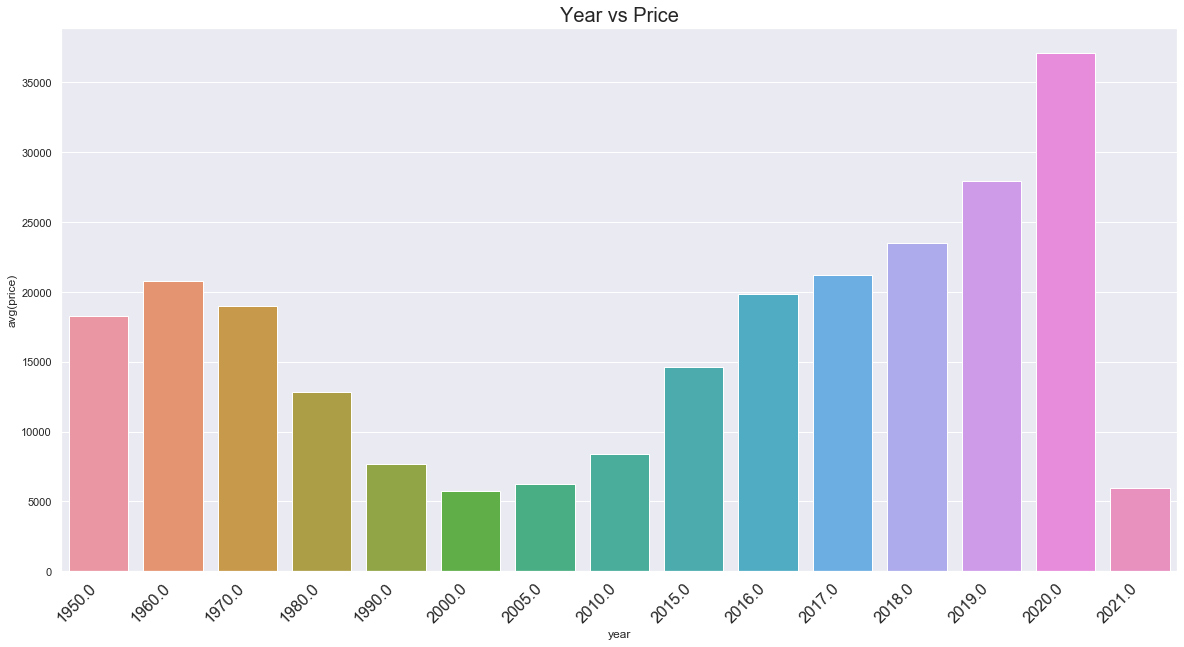

In [29]:
age_table = sqldf("""select year, count(year), avg(price)
            from df
            group by year
            order by avg(price) DESC
            limit 15""")
print(age_table)
sns.set(style="darkgrid")
plt.figure(figsize=(20,10))
plt.title("Year vs Price", fontsize =20)
totalsChart = sns.barplot(data=age_table, x='year',y='avg(price)')
totalsChart.set_xticklabels(totalsChart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=16)

### 5. Odometer vs. Price

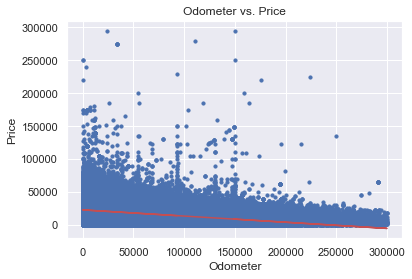

In [30]:


np.random.seed(0)
x = df['odometer']
y = df['price']

# transforming the data to include another axis
x = x[:, np.newaxis]
y = y[:, np.newaxis]

model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

plt.title("Odometer vs. Price")
plt.xlabel("Odometer")
plt.ylabel("Price")
plt.scatter(x, y, s=10)
plt.plot(x, y_pred, color='r')
plt.show()

### 6. Age vs. Price

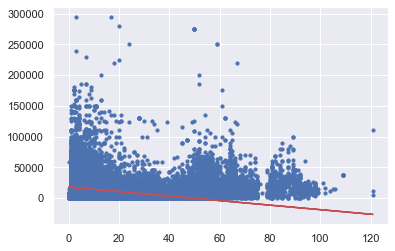

In [31]:


np.random.seed(0)
x = df['age']
y = df['price']

# transforming the data to include another axis
x = x[:, np.newaxis]
y = y[:, np.newaxis]

model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

plt.scatter(x, y, s=10)
plt.plot(x, y_pred, color='r')
plt.show()

### 7. Age vs. Price (degree=2)

9698.795360241516
0.24724476916924287


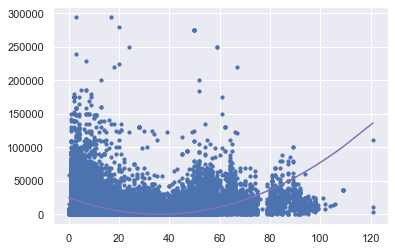

In [32]:


x = df['age']
y = df['price']

# transforming the data to include another axis
x = x[:, np.newaxis]
y = y[:, np.newaxis]

polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)

plt.scatter(x, y, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m')
plt.show()

These two graphs are very interesting because the first one shows us that as the age of the car goes up, the value goes down. The second graphs which is just the same graph with a polynomial feature shows us that really there is an inverted bell curve. The price of the car dips when it is around 20 years old and then it rises again. 

# Statistical Tests

### 1. 2 sample t-test of means comparing the price of cars for electric and gas. 
- H0: electric cars and gas cars cost the same on average 
- Ha: electric cars and gas cars dont cost the same on average
- Conclusion: since the p-value is less than alpha you can reject the null hypothesis that electric cars and gas cars cost the same

In [33]:

gas = df[df['fuel']=='gas']
electric = df[df['fuel']=='electric']
stats.ttest_ind(gas['price'], electric['price'])

Ttest_indResult(statistic=-29.91870827337057, pvalue=2.0322910967814036e-196)

### 2. Anova test comparing the miles traveled of a car and the manufacturer
- H0: there is no correlation between the manufacturer and the miles traveled of the car
- Ha: there is a correlation between the manufacturer and the miles traveled of the car
- Conclusion: since the p-value is less than alpha you can reject the null hypothesis that there is no correlation between manufacturer and miles traveled of a car

In [34]:
# The most popular manufacturers on craigslist 

ford = df[df['manufacturer']=='ford']
chevrolet = df[df['manufacturer']=='chevrolet']
toyota = df[df['manufacturer']=='toyota']
nissan = df[df['manufacturer']=='nissan']
honda = df[df['manufacturer']=='honda']
stats.f_oneway(ford['odometer'], chevrolet['odometer'], toyota['odometer'], nissan['odometer'], honda['odometer'])

F_onewayResult(statistic=713.7323615769511, pvalue=0.0)

### 3. One sample t-test comparing the mean age of a car on craigslist to the mean age of a car on the road
- source: 12 years: https://www.usatoday.com/story/money/cars/2020/07/28/covid-average-vehicle-age-12-years/5524832002/
- H0: mean age of car on craigslist = mean age of car on road
- Ha: mean age of car on craigslist != mean age of car on road
- Conclusion: since the p-value is less than alpha you can reject the null hypothesis that mean age of car on craigslist = mean age of car on road


In [35]:
mean_age = df['age']
stats.ttest_1samp(mean_age, 12)

Ttest_1sampResult(statistic=-68.26051379894032, pvalue=0.0)

These tests helped in building the model as it allowed me to compare whether or not there was a significant difference in the price of electric vs gas cars. It also allowed to to see whether or not the mean age of cars on the road is similar to the mean age of cars on craigslist. Surprisingly, the cars on the road are younger than the used cars on craigslist. This helped me build a model because I normalized the age column by taking log(age + .1). I also measured gas vs electric and then made those dummy variables because the test showed that electric and gas cars dont cost the same 

## Baseline RMSE

In [36]:
base = ['age', 'odometer']
target = df['price']
scaler = StandardScaler()
scaler.fit(df[base])
lm = linear_model.LinearRegression()
lm = lm.fit(df[base], target)
predictions = lm.predict(df[base])
rmse = np.sqrt(metrics.mean_squared_error(predictions, target))
print(rmse)

9722.33605165766


# Modeling

### Identify categorical and create dummy columns

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384445 entries, 0 to 435848
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            384445 non-null  int64  
 1   region        384445 non-null  object 
 2   price         384445 non-null  int64  
 3   year          384445 non-null  float64
 4   manufacturer  384445 non-null  object 
 5   model         384445 non-null  object 
 6   condition     384445 non-null  object 
 7   cylinders     384445 non-null  object 
 8   fuel          384445 non-null  object 
 9   odometer      384445 non-null  float64
 10  transmission  384445 non-null  object 
 11  drive         384445 non-null  object 
 12  type          384445 non-null  object 
 13  state         384445 non-null  object 
 14  age           384445 non-null  float64
dtypes: float64(3), int64(2), object(10)
memory usage: 46.9+ MB


In [38]:
# state
st_dummies = pd.get_dummies(df['state'], drop_first=True, prefix='st_')
# type
type_dummies = pd.get_dummies(df['type'], drop_first=True, prefix='type_')
# drive
drive_dummies = pd.get_dummies(df['drive'], drop_first=True, prefix='drive_')
# transmission
trans_dummies = pd.get_dummies(df['transmission'], drop_first=True, prefix='trans_')
# fuel
fuel_dummies = pd.get_dummies(df['fuel'], drop_first=True, prefix='fuel_')
# cylinders
cyl_dummies = pd.get_dummies(df['cylinders'], drop_first=True, prefix='cyl_')
# condition
cond_dummies = pd.get_dummies(df['condition'], drop_first=True, prefix='cond_')
# manufacturer
man_dummies = pd.get_dummies(df['manufacturer'], drop_first=True, prefix='man_')
# year
year_dummies = pd.get_dummies(df['year'], drop_first=True, prefix='year_')

df = df.drop(['state','type','drive', 'transmission', 'fuel', 'cylinders', 'condition',
                             'manufacturer', 'year'], axis=1)

df = pd.concat([df, st_dummies, type_dummies, drive_dummies, trans_dummies, fuel_dummies, 
                       cyl_dummies, cond_dummies, man_dummies, year_dummies], axis=1)
df.head()


,id,region,price,model,odometer,age,st__al,st__ar,st__az,st__ca,...,year__2000.0,year__2005.0,year__2010.0,year__2015.0,year__2016.0,year__2017.0,year__2018.0,year__2019.0,year__2020.0,year__2021.0
0,7119256118,mohave county,3495,patriot,93000.0,9.0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,7120880186,oregon coast,13750,328i m-sport,76237.0,7.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,7115048251,greenville / upstate,2300,caravan,199000.0,20.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,7119250502,mohave county,9000,colorado ls,54000.0,17.0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
7,7120430837,maine,8500,mustang convertible,62800.0,16.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [39]:
# Identify Multicollinearity
dt_pred = df

In [40]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df1=dt_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df1['pairs'] = list(zip(df1.level_0, df1.level_1))

# set index to pairs
df1.set_index(['pairs'], inplace = True)

#drop level columns
df1.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df1.columns = ['cc']
df1.drop_duplicates(inplace=True)

In [41]:
df1[(df1.cc>.75) & (df1.cc <1)]

,cc
pairs,
"(fuel__gas, fuel__diesel)",0.766118


In [42]:

outcome = 'price'
x_cols = ['age', 'odometer']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                 6.190e+04
Date:                Thu, 30 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:38:26   Log-Likelihood:            -4.0755e+06
No. Observations:              384445   AIC:                         8.151e+06
Df Residuals:                  384442   BIC:                         8.151e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.426e+04     33.908    715.484      0.000    2.42e+04    2.43e+04
age         -211.1052      1.859   -113.561      0.000    -214.749    -207.462
odometer      -0.0838      0.000   -284.205      0.000      -0.084      -0.083
==============================================================================
Omnibus:                   292291.064   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         21431117.504
Skew:                           3.071   Prob(JB):                         0.00
Kurtosis:                      39.058   Cond. No.                     2.44e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Neither of the continuous variables have a p-val > .05 so I kept them in the data set

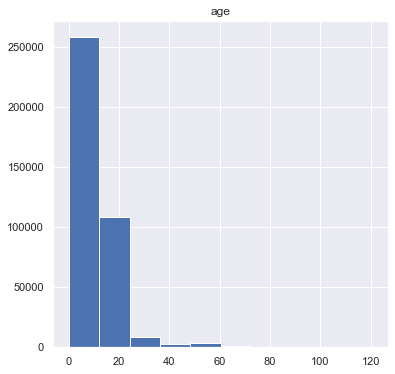

In [43]:
data_pred = df
data_pred[['age']].hist(figsize  = [6, 6]); 

In [44]:
#df['age'] = df['age']+.01
# add .01 bc cant take log of 0

In [45]:
df['logage'] = np.log(data_pred['age']+1)

### Train-Test-Split

In [46]:
features = ['odometer', 'logage', 'st__al', 'st__ar', 'st__az', 'st__ca', 'st__co', 'st__ct', 'st__dc', 'st__de', 'st__fl', 'st__ga', 'st__hi', 'st__ia', 'st__id', 'st__il', 'st__in', 'st__ks', 'st__ky', 'st__la', 'st__ma', 'st__md', 'st__me', 'st__mi', 'st__mn', 'st__mo', 'st__ms', 'st__mt', 'st__nc', 'st__nd', 'st__ne', 'st__nh', 'st__nj', 'st__nm', 'st__nv', 'st__ny', 'st__oh', 'st__ok', 'st__or', 'st__pa', 'st__ri', 'st__sc', 'st__sd', 'st__tn', 'st__tx', 'st__ut', 'st__va', 'st__vt', 'st__wa', 'st__wi', 'st__wv', 'st__wy', 'type__Unknown', 'type__bus', 'type__convertible', 'type__coupe', 'type__hatchback', 'type__mini-van', 'type__offroad', 'type__other', 'type__pickup', 'type__sedan', 'type__truck', 'type__van', 'type__wagon', 'drive__Unknown', 'drive__fwd', 'drive__rwd', 'trans__automatic', 'trans__manual', 'trans__other', 'fuel__diesel', 'fuel__electric', 'fuel__gas', 'fuel__hybrid', 'fuel__other', 'cyl__12 cylinders', 'cyl__3 cylinders', 'cyl__4 cylinders', 'cyl__5 cylinders', 'cyl__6 cylinders', 'cyl__8 cylinders', 'cyl__Unknown', 'cyl__other', 'cond__1', 'cond__2', 'cond__Unknown', 'man__alfa-romeo', 'man__aston-martin', 'man__audi', 'man__bmw', 'man__buick', 'man__cadillac', 'man__chevrolet', 'man__chrysler', 'man__datsun', 'man__dodge', 'man__ferrari', 'man__fiat', 'man__ford', 'man__gmc', 'man__harley-davidson', 'man__honda', 'man__hyundai', 'man__infiniti', 'man__jaguar', 'man__jeep', 'man__kia', 'man__land rover', 'man__lexus', 'man__lincoln', 'man__mazda', 'man__mercedes-benz', 'man__mercury', 'man__mini', 'man__mitsubishi', 'man__morgan', 'man__nissan', 'man__pontiac', 'man__porche', 'man__ram', 'man__rover', 'man__saturn', 'man__subaru', 'man__tesla', 'man__toyota', 'man__volkswagen', 'man__volvo', 'year__1960.0', 'year__1970.0', 'year__1980.0', 'year__1990.0', 'year__2000.0', 'year__2005.0', 'year__2010.0', 'year__2015.0', 'year__2016.0', 'year__2017.0', 'year__2018.0', 'year__2019.0', 'year__2020.0', 'year__2021.0']
target = df['price']
df_features = df[features]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=34,test_size=0.3)
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X_train.columns)
lm = LinearRegression()
lm = lm.fit(X_train, y_train)
y_train_pred = lm.predict(X_train)
y_pred = lm.predict(X_test)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
print('Training RMSE:' , train_rmse)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Testing RMSE:' , test_rmse)

Training RMSE: 7113.714250046302
Testing RMSE: 7177.686579108247


The model is fit as the test error is almost equal to the training error

In [48]:
#baseline model with log age
base = ['logage', 'odometer']
scaler = StandardScaler()
scaler.fit(df[base])
lm = linear_model.LinearRegression()
lm = lm.fit(df[base], target)
predictions = lm.predict(df[base])
rmse = np.sqrt(metrics.mean_squared_error(predictions, target))
print(rmse)

9419.548975320044


In [49]:
# Model with all features
scaler = StandardScaler()
scaler.fit(df[features])
lm = linear_model.LinearRegression()
lm = lm.fit(df[features], target)
predictions = lm.predict(df[features])
rmse = np.sqrt(metrics.mean_squared_error(predictions, target))
print(rmse)

7130.729169077128


### F test

In [50]:
selector = SelectKBest(f_regression, k=55)
selector.fit(X_train, y_train)
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [51]:
#instantiate a linear regression object
lm_kbest = LinearRegression()
#fit the linear regression to the data
lm_kbest = lm_kbest.fit(X_train[selected_columns], y_train)

y_train_kbest = lm_kbest.predict(X_train[selected_columns])
y_kbest = lm_kbest.predict(X_test[selected_columns])

trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))
testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))

print('Training Root Mean Squared Error:' , trainK_rmse)
print('Testing Root Mean Squared Error:' , testK_rmse)
print('Original: ', test_rmse, "vs. KBest: ", testK_rmse)

Training Root Mean Squared Error: 7295.867886907799
Testing Root Mean Squared Error: 7372.950639960511
Original:  7177.686579108247 vs. KBest:  7372.950639960511


### Lasso

In [52]:
## training the model


lasso = Lasso(alpha=1, normalize=False)
lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )


/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6955856747262.004, tolerance: 3369953626.401535
  positive)


Training Error: 7128.2558943354725
Testing Error: 7184.04095420096


In [53]:
pd.set_option('display.max_rows', 150)

In [54]:
lasso_coef = pd.DataFrame(data=lasso.coef_).T
lasso_coef.columns = X_train.columns
lasso_coef.T

,0
odometer,-0.043431
logage,-8059.723574
st__al,333.619071
st__ar,763.896183
st__az,-65.920817
st__ca,280.476949
st__co,409.070858
st__ct,-651.382769
st__dc,-1078.374219
st__de,-0.000000


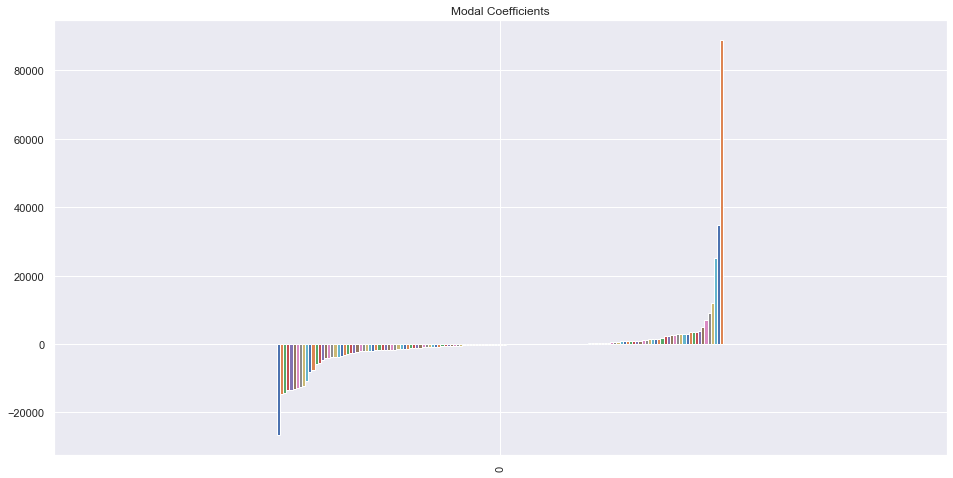

In [55]:
lasso_coef = lasso_coef.T.sort_values(by=0).T
lasso_coef.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))

The model is fit as the test error is almost equal to the training error

My final model shows that my RMSE is around 7000 off from predicting the true price. I used the lasso model because that showed the lowest RMSE. The odometer coffecient shows that for each additional mile the car is driven, the price will go down -.04, and for each additional logarithmic age of the car, the value goes down by 8000

## Refitting the best model to the dataset

In [56]:

scaler = StandardScaler()
final_scaled = scaler.fit_transform(df_features)

In [57]:
lasso1 = Lasso(alpha=1, normalize=False)
lasso1.fit(final_scaled, target)

/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2245475266998.3496, tolerance: 4804144115.209858
  positive)


Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [58]:
lasso1.coef_

array([-2.34498712e+03, -5.88498352e+03,  1.16294990e+01,  6.11485607e+01,
       -5.71399783e+01, -2.07618822e+01,  1.34530817e+01, -1.08303294e+02,
       -1.17570646e+02, -2.13345490e+01, -3.79849980e+02, -7.44778696e+01,
        6.58976717e+01, -1.17231523e+02,  1.02389740e+02, -2.22149568e+02,
       -6.01862194e+01, -3.88312373e+01, -5.08699013e+01, -9.45450533e+01,
       -2.64225239e+02, -1.12700270e+02, -2.72957398e+02, -1.56426477e+02,
       -8.33581398e+01,  6.50439214e+00, -2.12227358e+01,  3.07487666e+02,
       -2.57231942e+01,  2.96089225e+00, -1.85805030e+01, -2.11295677e+02,
       -2.64845915e+02, -2.06321809e+01, -2.91640428e+01, -2.37557791e+02,
       -2.61687760e+02, -1.54872811e+01, -1.05714788e+02, -1.71913773e+02,
       -7.53076611e+01,  1.99405128e+01,  3.00808342e+01, -5.84367702e+01,
       -1.53472911e+02,  2.71454669e+01, -7.85353920e+01, -2.20453456e+02,
        2.23696244e+02, -4.94897113e+01,  9.56485822e+00,  3.72806975e+01,
       -1.42917009e+02,  